In [1]:
import torch
import numpy as np
import torch.nn as nn
import tensorrt as trt
from torch2trt.calibration import DatasetCalibrator, TensorBatchDataset

/usr/local/lib/python3.6/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
!echo 'adlink' | sudo -S python3 export.py --weights yolov7-tiny.pt --device 0 --simplify --grid --simplify --end2end_trt --topk-all 100

[sudo] password for adlink: Namespace(batch_size=1, calib_algo='entropy2', calib_batch_size=4, calib_num_images=200, calibrate=False, conf_thres=0.6, device='0', end2end_trt=True, fp16=False, grid=True, img_size=[640, 640], include_nms=False, int8=False, iou_thres=0.001, seed=10, simplify=True, topk_all=100, weights='yolov7-tiny.pt', workspace=28)
YOLOR 🚀 v0.1-105-g064c71e torch 1.8.0 CUDA:0 (Xavier, 7773.484375MB)

Fusing layers... 
Model Summary: 200 layers, 6219709 parameters, 6219709 gradients, 13.7 GFLOPS

Starting ONNX export with onnx 1.8.1...
/home/adlink/Object-Detection-with-Jetson/yolov7/models/yolo.py:52: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != x[i].shape[2:4]:

Starting to simplify ONNX...
Starting ONNX graph surgery
Gra

[08/20/2022-01:52:21] [TRT] [I] Some tactics do not have sufficient workspace memory to run. Increasing workspace size may increase performance, please check verbose output.
[08/20/2022-01:56:35] [TRT] [I] Detected 1 inputs and 4 output network tensors.
[08/20/2022-01:56:35] [TRT] [I] Total Host Persistent Memory: 119328
[08/20/2022-01:56:35] [TRT] [I] Total Device Persistent Memory: 50558976
[08/20/2022-01:56:35] [TRT] [I] Total Scratch Memory: 48384768
[08/20/2022-01:56:35] [TRT] [I] [MemUsageStats] Peak memory usage of TRT CPU/GPU memory allocators: CPU 7 MiB, GPU 499 MiB
[08/20/2022-01:56:35] [TRT] [I] [BlockAssignment] Algorithm ShiftNTopDown took 69.1102ms to assign 9 blocks to 121 nodes requiring 71399425 bytes.
[08/20/2022-01:56:35] [TRT] [I] Total Activation Memory: 71399425
[08/20/2022-01:56:35] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +1, GPU +0, now: CPU 3043, GPU 7536 (MiB)
[08/20/2022-01:56:35] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +0, now: CPU 30

In [3]:
import cv2
import random
import time
from PIL import Image
from pathlib import Path
from collections import OrderedDict, namedtuple

In [13]:
w = 'yolov7-tiny.engine'
device = torch.device('cuda:0')
img = cv2.imread('inference/images/horses.jpg')

In [18]:
Binding = namedtuple('Binding', ('name', 'dtype', 'shape', 'data', 'ptr'))
logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, namespace="")
with open(w, 'rb') as f, trt.Runtime(logger) as runtime:
    model = runtime.deserialize_cuda_engine(f.read())
bindings = OrderedDict()
for index in range(model.num_bindings):
    name = model.get_binding_name(index)
    dtype = trt.nptype(model.get_binding_dtype(index))
    shape = tuple(model.get_binding_shape(index))
    data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
    bindings[name] = Binding(name, dtype, shape, data, int(data.data_ptr()))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
context = model.create_execution_context()


def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    shape = im.shape[:2]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]#

    if auto:
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)#

    dw /= 2
    dh /= 2#

    if shape[::-1] != new_unpad:
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return im, r, (dw, dh)

def postprocess(boxes,r,dwdh):
    dwdh = torch.tensor(dwdh*2).to(boxes.device)
    boxes -= dwdh
    boxes /= r
    return boxes

names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

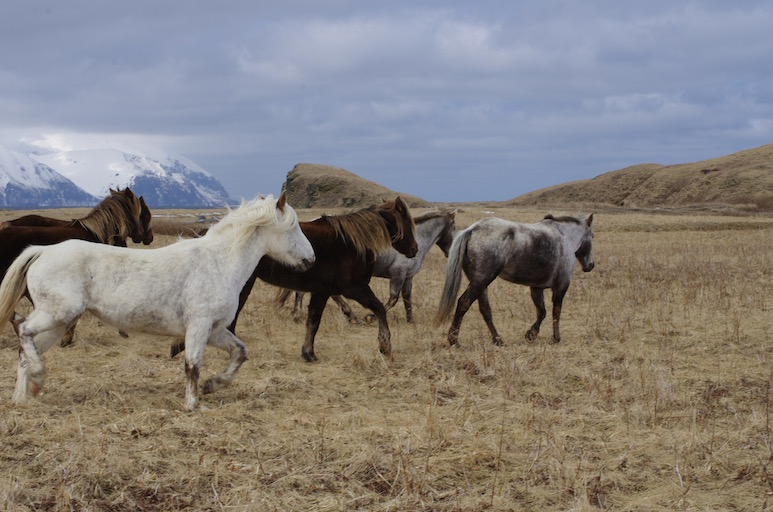

In [51]:
img = cv2.imread('inference/images/horses.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = img.copy()

image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
Image.fromarray(img)

In [52]:
im = torch.from_numpy(im).to(device)
im/=255
im.shape

torch.Size([1, 3, 640, 640])

torch.Size([1, 3, 640, 640])
torch.Size([1, 3, 640, 640])
Cost 0.029185134999352158 s
(640, 640, 3)
tensor([437, 212, 596, 347], device='cuda:0', dtype=torch.int32)
tensor([362, 284, 494, 396], device='cuda:0', dtype=torch.int32)
tensor([ -1, 189, 317, 411], device='cuda:0', dtype=torch.int32)
tensor([ -1, 265, 262, 448], device='cuda:0', dtype=torch.int32)
tensor([260, 196, 424, 366], device='cuda:0', dtype=torch.int32)
tensor([215, 270, 351, 411], device='cuda:0', dtype=torch.int32)
tensor([ -1, 185, 156, 274], device='cuda:0', dtype=torch.int32)
tensor([ -1, 261, 129, 334], device='cuda:0', dtype=torch.int32)
tensor([370, 209, 457, 319], device='cuda:0', dtype=torch.int32)
tensor([306, 281, 378, 372], device='cuda:0', dtype=torch.int32)


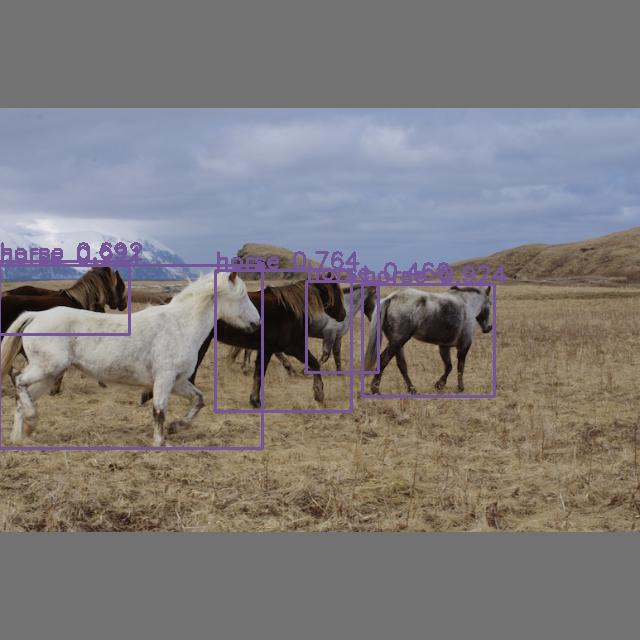

In [94]:
# warmup for 10 times
#print(im)
print(im.shape)
im2 = im.clone().detach().cpu()
print(im2.shape)
for _ in range(10):
    tmp = torch.randn(1,3,640,640).to(device)
    binding_addrs['images'] = int(tmp.data_ptr())
    context.execute_v2(list(binding_addrs.values()))

start = time.perf_counter()
binding_addrs['images'] = int(im.data_ptr())
context.execute_v2(list(binding_addrs.values()))
print(f'Cost {time.perf_counter()-start} s')

nums = bindings['num'].data
boxes = bindings['boxes'].data
scores = bindings['scores'].data
classes = bindings['classes'].data
nums.shape,boxes.shape,scores.shape,classes.shape

boxes = boxes[0,:nums[0][0]]
scores = scores[0,:nums[0][0]]
classes = classes[0,:nums[0][0]]

im2 = im2 * 255
im2 = im2[0].numpy().astype(np.uint8).transpose(1,2,0).copy()
print(im2.shape)
#Image.fromarray(im2)
#print(img.shape)

for box,score,cl in zip(boxes,scores,classes):
    box2 = postprocess(box.clone(),ratio,dwdh).round().int()
    #print(box2)
    box = box.round().int()
    print(box)
    name = names[cl]
    color = colors[name]
    name += ' ' + str(round(float(score),3))
    #cv2.rectangle(img,box[:2].tolist(),box[2:].tolist(),color,2)
    #cv2.putText(img,name,(int(box[0]), int(box[1]) - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,color,thickness=2)
    cv2.rectangle(im2,box[:2].tolist(),box[2:].tolist(),color,2)
    cv2.putText(im2,name,(int(box[0]), int(box[1]) - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,color,thickness=2)

#Image.fromarray(img)
#print
Image.fromarray(im2)